In [5]:
%load_ext autoreload
%autoreload 2

import pretty_errors
pretty_errors.configure(
    separator_character = '*',
    filename_display    = pretty_errors.FILENAME_EXTENDED,
    line_number_first   = True,
    display_link        = True,
    lines_before        = 5,
    lines_after         = 2,
    line_color          = pretty_errors.RED + '> ' + pretty_errors.default_config.line_color,
    code_color          = '  ' + pretty_errors.default_config.line_color,
    truncate_code       = True,
    display_locals      = True
)

import matplotlib.pyplot as plt
import seaborn as sns
from mplrc import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from _rnd import *
from _utils import *
from err_analysis import *
# from matplotlib import rc

from os.path import expanduser
import os

home = expanduser("~")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
OneDataMultipleErrorBound: loading data from the existing
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000
sum: 6480000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

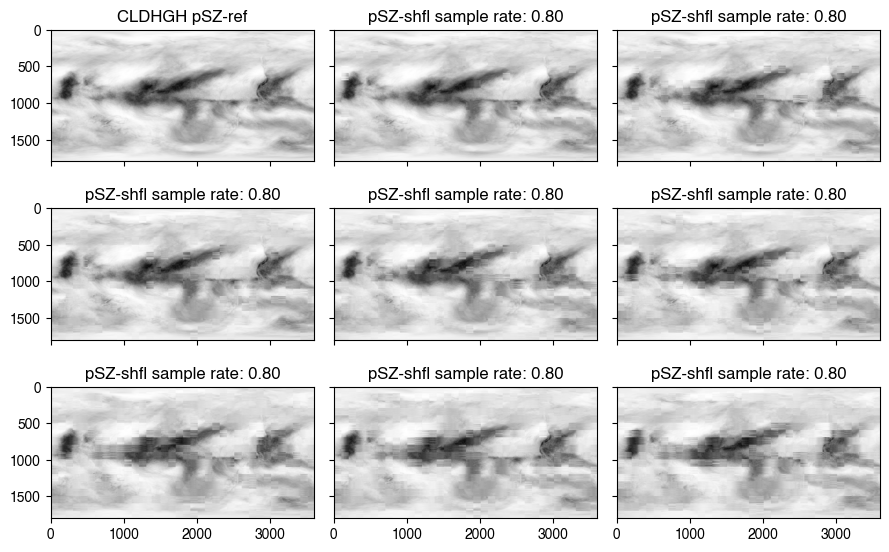

/Users/jti1/.anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


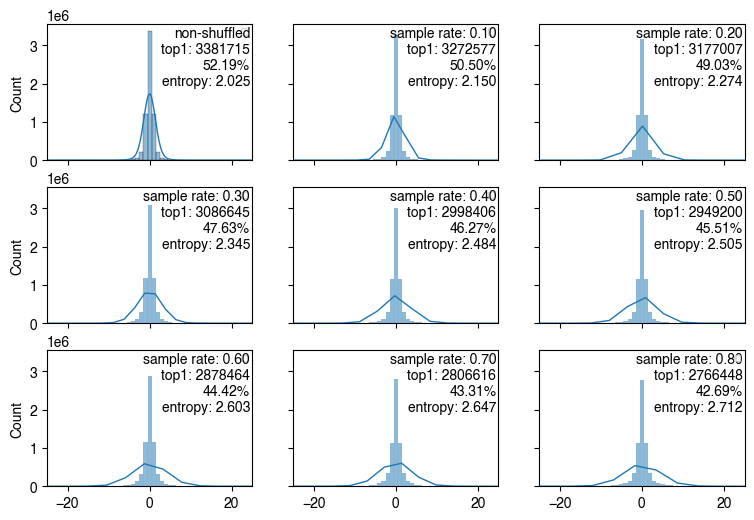

In [7]:
data = load_data(os.path.join(home, "cesm_dim3-3600x1800", "CLDHGH.f32"), (1800, 3600), "f4")

sample_rates = np.arange(0.1, 0.9, 0.1)

# eb_list = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
eb_list = [1e-3]

linearized_len = np.product(data.shape)

normal = OneDataMultipleErrorBound(data=data)
normal.run_psz(eb_list, if_rel2rng=True)

shuffled_list = []
for rate in sample_rates:
    __shuffled = np.zeros_like(data)
    randomize_blocks(data, __shuffled, sample_rate=rate)
    shuffled_list.append(OneDataMultipleErrorBound(data=__shuffled))
    shuffled_list[-1].run_psz(eb_list, if_rel2rng=True)

fig2, axs2 = plt.subplots(ncols=3, nrows=int(len(shuffled_list)/3 + 0.5), sharey="all", sharex='all', figsize=(9, 6))
axs2.flat[0].imshow(data, cmap='gray_r')
axs2.flat[0].set_title("CLDHGH pSZ-ref")
for i, s in enumerate(shuffled_list):
    axs2.flat[i + 1].imshow(s.data.data, cmap='gray_r')
    axs2.flat[1 + i].set_title(f"pSZ-shfl sample rate: {rate:.2f}")
fig2.tight_layout()


fig1, axs1 = plt.subplots(ncols=3, nrows=int(len(shuffled_list)/3 + 0.5), sharex='all', sharey="all", figsize=(9, 6))

for eb, hist in zip(normal.eb_list_input, normal.psz.hist_errquant):
    hx, hy = normal.hist_xy(hist)
    print(f"sum: {np.sum(hy)}")

    top1 = np.max(hy)
    en = entropy(hy)
    sns.histplot(
        ax=axs1.flat[0],
        # bins=50,
        x=hx,
        weights=hy,
        discrete=True,
        kde=True,
        line_kws={"linewidth": 1},
    )
plt.text(.99, .99, f"non-shuffled\ntop1: {top1}\n{100*top1/linearized_len:.2f}%\nentropy: {en:.3f}", ha='right', va='top', transform=axs1.flat[0].transAxes)


for i, s in enumerate(shuffled_list):
    for eb, hist in zip(s.eb_list_input, s.psz.hist_errquant):
        hx, hy = s.hist_xy(hist)
        print(f"sum: {np.sum(hy)}")
        top1 = np.max(hy)
        en = entropy(hy)
        sns.histplot(
            ax=axs1.flat[1 + i],
            x=hx,
            weights=hy,
            discrete=True,
            kde=True,
            line_kws={"linewidth": 1},
        )
    plt.text(.99, .99, f"sample rate: {i * 0.1 + 0.1:.2f}\ntop1: {top1}\n" + f"{100*top1/linearized_len:.2f}%\nentropy: {en:.3f}", ha='right', va='top', transform=axs1.flat[i+1].transAxes)

for ax in axs1.flat:
    # ax.set_ylim(100, 1e7)
    # ax.set_yscale("log")
    ax.legend(fontsize=6)
for i, rate in enumerate(sample_rates):
    # axs1.flat[1 + i].set_title(f"pSZ-shfl sample rate: {rate:.2f}")
    axs1.flat[1 + i].set_xlim(axs1.flat[0].get_xlim())
axs1.flat[0].set_xlim([-25, 25])

fig1.tight_layout()

fig1.savefig("fig1.png", dpi=300, bbox_inches='tight')
fig2.savefig("fig2.png", dpi=300, bbox_inches='tight')